# Construction of a prediction model for Covid19
## Part 2 of the notebook (for part one look at the fork of covidclinicaldata

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from colorama import Fore #To pain the terminal with different colors
import warnings
warnings.filterwarnings('ignore') #To disable warnings
from IPython.display import display #To print a dataframe like the cell does

In [2]:
all_data = pd.read_csv("covid_clinical_data.csv", index_col=0)
all_data

,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,autoimmune_dis,...,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,Negative,4,True,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
1,Negative,2,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
2,Negative,1,NaN,NaN,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Negative,3,True,True,False,False,False,False,False,False,...,True,2.0,False,True,False,False,False,False,False,True
4,Negative,1,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93989,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93990,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,True,False,True
93991,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93993,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False


In [3]:
X = all_data.iloc[:, 1:]
y = all_data["covid19_test_results"]

In [208]:
def create_different_datasets(data_x):
    e_factors = data_x.iloc[:,:3]
    comorbidities_data = data_x.iloc[:, 3:10] #The columns that contain the comorbidities
    vitals_data = data_x.iloc[:, 10:16] #The columns that contain the vitals
    assesed_symptoms_data = data_x.iloc[:, 16:21] #The columns that contain the assesed symptoms
    reported_symptoms_data = data_x.iloc[:,21:] #The columns that have the patient reported symptoms
    
    return e_factors, comorbidities_data, vitals_data, assesed_symptoms_data, reported_symptoms_data

In [209]:
e_factors, comorb, vitals, a_symptoms, r_symptoms = create_different_datasets(X)

<u>high_risk_exposure_occupation:</u> The most obvious thing to do is to just fill the 169 missing values with the most frequent value. However, it occurred to me that since we ultimately are willing to have (maybe even encourage) false positives, it might be better to just put the ones that tested positive as True and the rest as False. This would require that I split the dataset into training, validation and testing set before I do any imputation to avoid any target leakage (the effect when knowing the result before hand affects how are we imputing the variables). The step to be taken (if I were to follow that route) would be then to impute the training data that tested positive as True, the rest as False, and any incoming unknown data (validation and test data) as True if we dont know the value of the feature. I might need to run an experiment when I do both.

<u>high_risk_interaction:</u> This is easier than the previous one. We will just assign True to anything that has a 'high_risk_expossure_occupation' as True. The reasoning behind is is that if we don't know if the patient has had a high risk interaction, makes sense to say they did if their occupation is of high risk exposure.

In [96]:
def high_risk_exposure_imputation(data_x, data_y, target_imputation=False):    
    if target_imputation:
        mode = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]
    else:
        mode = True
    data_x.loc[data_x["high_risk_exposure_occupation"].isna(), "high_risk_exposure_occupation"] = mode
    
    data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]

def vitals_imputation_generic(data_x):
    data = data_x.copy()
    data.loc[data["temperature"].isna(),"temperature"] = data["temperature"].mean()
    data.loc[data["pulse"].isna(),"pulse"] = data["pulse"].median()
    data.loc[data["rr"].isna(),"rr"] = data["rr"].median()
    data.loc[data["sats"].isna(),"sats"] = data["sats"].median()
    data.loc[data_x["pam"].isna(), "pam"] = data_x["pam"].mean()
    
    return data


In [7]:
def reduce_training_set(data_x, data_y):
    selected_negatives = data_x[data_y[data_x.index] == "Negative"].sample((data_y[data_x.index] == "Positive").sum())
    all_positives = data_x[data_y == "Positive"]
    #reduced_train_comorb = pd.merge(all_positives, selected_negatives) #Doesn't work well for reasons...
    reduced_data = pd.concat([all_positives, selected_negatives])

    return reduced_data

def get_metrics(*values):
    accuracy = accuracy_score(*values)
    recall = recall_score(*values, pos_label="Positive")
    precision = precision_score(*values, pos_label="Positive")
    f1 = f1_score(*values, pos_label="Positive")
    return accuracy, recall, precision, f1


In [200]:
class Imputer():
    
    def __init__(self):
        self.column_values = {}
        
    def fit_transform(self, data_x, data_y):
        self.fit(data_x, data_y)
        self.transform(data_x, training=True)
        
    def fit(self, data_x, data_y):
        self.get_high_risk_exposure_value(data_x, data_y)
        self.get_vitals_values(data_x)
        
    def transform(self, data_x, training=False):
        
        for feature in data_x.columns:           
            
            if feature in self.column_values:
                new_value = self.column_values[feature]
                
                if feature == "high_risk_exposure_occupation" and not training:
                    new_value=True
                    
                data_x.loc[data_x[feature].isna(), feature] = new_value
                
        if "high_risk_interactions" in data_x.columns: #Because this depends on 'high_risk_exposure_occupation being imputed first'
            data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]
        
        
        
    def get_high_risk_exposure_value(self, data_x, data_y):
        if "high_risk_exposure_occupation" in data_x.columns:
            self.column_values["high_risk_exposure_occupation"] = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]

        
    def get_vitals_values(self, data_x):
        if "temperature" in data_x.columns:
            self.column_values["temperature"] =  data_x["temperature"].mean()
        if "pulse" in data_x.columns:
            self.column_values["pulse"] = data_x["pulse"].median()
        if "rr" in data_x.columns:
            self.column_values["rr"] = data_x["rr"].median()
        if "sats" in data_x.columns:
            self.column_values["sats"] = data_x["sats"].median()
        if "pam" in data_x.columns:
            self.column_values["pam"] =  data_x["pam"].mean()
    

In [144]:
class XGBAdapter:
    
    def __init__(self, **params):
        self.model = XGBClassifier(**params, verbosity=0)
        
    def fit(self, data_x, data_y):
        self.model.fit(self.xgb_adapter(data_x), data_y)
        
    def predict(self, data_x):
        return self.model.predict(self.xgb_adapter(data_x))
        
    #This function is because xgb complains about 'object' type columns so I convert them all to boolean
    def xgb_adapter(self, data_x):
        result = data_x.copy()
        for column in result:
            if data_x[column].dtype == "object":
                result.loc[:,column] = result[column].astype("bool")
        return result

In [193]:
def cross_validation_normal(data_x, data_y, model, folds):
    results = np.zeros((folds,2,4)) #Shape of folds, training and validation, and number of metrics
    
    fold_size = data_x.shape[0] // folds
    reminder = data_x.shape[0] % folds    
    start = 0    
    imputer = Imputer()
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1
        train_x = pd.concat([data_x.iloc[:start], data_x.iloc[end:]], axis=0)
        train_y = data_y.iloc[:start].append(data_y.iloc[end:])
        valid_x = data_x.iloc[start:end]
        valid_y = data_y.iloc[start:end]
        
        #if hr_imputation:
            #high_risk_exposure_imputation(train_x, train_y, target_imputation = True)
            #high_risk_exposure_imputation(valid_x, valid_y)
            
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
            
        model.fit(train_x, train_y)
        train_v = (train_y, model.predict(train_x))
        valid_v = (valid_y, model.predict(valid_x))
        results[i,0] += get_metrics(*train_v)
        results[i,1] += get_metrics(*valid_v)
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
    print("")
    return results.mean(axis=0)

def cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1):
    
    positive_index = data_y[data_y == "Positive"].index
    size_of_negatives = positive_index.shape[0] * ratio_negatives_to_positives
    
    fold_size = positive_index.shape[0] // folds
    results = np.zeros((folds,2,4)) #Shape of folds, training and validation, and number of metrics   
        
    reminder = positive_index.shape[0] % folds
    
    imputer = Imputer()
    start = 0    
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1        
        training_positives = np.setdiff1d(positive_index, positive_index[start:end]) #The index of positives to be used as training set
                
        # Sample the size of negatives- the size of the fold negatives for training and concatenate with the corresponding indexes for the fold
        train_x = pd.concat([data_x[data_y == "Negative"].sample(size_of_negatives - fold_size), data_x.loc[training_positives]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        train_y = data_y[train_x.index]
        valid_x = pd.concat([data_x[data_y == "Negative"].sample(fold_size * ratio_negatives_to_positives), data_x.loc[positive_index[start:end]]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        valid_y = data_y[valid_x.index]
        
        #if hr_imputation:
            #high_risk_exposure_imputation(train_x, train_y, target_imputation = True)
            #high_risk_exposure_imputation(valid_x, valid_y)
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
        
            
        model.fit(train_x, train_y)
        train_v = (train_y, model.predict(train_x))
        valid_v = (valid_y, model.predict(valid_x))
        results[i,0] += get_metrics(*train_v)
        results[i,1] += get_metrics(*valid_v)
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
    print("")
    return results.mean(axis=0)
    
        
def run_models_cross_val(data_x, data_y, models, folds=10, ratio_negatives_to_positives=-1):
    for model in models:
        print(Fore.RED, model, Fore.BLACK, sep="")
        if(ratio_negatives_to_positives >= 1):            
            results = cross_validation_class_ratios(data_x, data_y, models[model], folds, ratio_negatives_to_positives)
        else:
            results = cross_validation_normal(data_x, data_y, models[model], folds)    
            
        display(pd.DataFrame(results, index=["Training", "Validation"], columns=["Accuracy", "Recall", "Precision", "F1"]))
        print("")

In [201]:
models ={
    "MultinomialNB" : MultinomialNB(alpha=0, class_prior=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=30),
    "XGBoost Classifier" : XGBAdapter(n_estimators=500),
    "SVM" : SVC()    
}

In [133]:
run_models_cross_val(comorb, y[comorb.index], models)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.904953,0.083474,0.026178,0.039854
Validation,0.905138,0.082413,0.024478,0.037117



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976361,0.0,0.0,0.0
Validation,0.976362,0.0,0.0,0.0



Random Forest (500 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976361,0.0,0.0,0.0
Validation,0.976362,0.0,0.0,0.0



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976361,0.0,0.0,0.0
Validation,0.976362,0.0,0.0,0.0



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976361,0.0,0.0,0.0
Validation,0.976362,0.0,0.0,0.0


In [145]:
reduced_comorb = reduce_training_set(comorb, y)
run_models_cross_val(reduced_comorb, y[reduced_comorb.index], models)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.508328,0.082589,0.555629,0.143616
Validation,0.508068,0.040933,0.500000,0.075517



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.555465,0.5,0.277727,0.357101
Validation,0.000820,0.0,0.000000,0.000000



Random Forest (500 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.561648,0.508695,0.634238,0.384114
Validation,0.020047,0.011464,0.500000,0.022366



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.561602,0.508653,0.632571,0.384409
Validation,0.020042,0.012688,0.500000,0.024702



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.561648,0.509349,0.638649,0.383587
Validation,0.016770,0.011056,0.500000,0.021579


In [14]:
comorb_ef = pd.concat([comorb, e_factors], axis=1)
run_models_cross_val(comorb_ef, y, models)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.717952,0.336155,0.030852,0.054799
Validation,0.708068,0.284088,0.025299,0.044059



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976361,0.0,0.0,0.0
Validation,0.976362,0.0,0.0,0.0



Random Forest (500 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976462,0.004278,1.0,0.008518
Validation,0.976323,0.000000,0.0,0.000000



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976398,0.001618,0.975,0.003229
Validation,0.976343,0.000000,0.000,0.000000



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976361,0.0,0.0,0.0
Validation,0.976362,0.0,0.0,0.0


In [15]:
reduced_comorb_ef = reduce_training_set(comorb_ef, y)
run_models_cross_val(reduced_comorb_ef, y[reduced_comorb_ef.index], models)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.542786,0.219806,0.618902,0.323843
Validation,0.534878,0.104259,0.500000,0.169969



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.576059,0.531760,0.582439,0.470681
Validation,0.131357,0.060137,0.500000,0.106996



Random Forest (500 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.601473,0.569141,0.626504,0.530950
Validation,0.205793,0.101407,0.500000,0.163972



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.585197,0.546377,0.58898,0.501353
Validation,0.183710,0.087504,0.50000,0.148112



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.582288,0.548177,0.583566,0.501532
Validation,0.186966,0.093631,0.500000,0.156285


Next step to either add more features or... implement a cross validation method that makes up for the difference between positives and negatives

In [136]:
run_models_cross_val(comorb, y[comorb.index], models, ratio_negatives_to_positives = 1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.505819,0.071200,0.575186,0.123336
Validation,0.497539,0.056384,0.523109,0.098896



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.513501,0.803520,0.513532,0.596898
Validation,0.495890,0.787912,0.468659,0.576260



Random Forest (500 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.519729,0.719723,0.53380,0.548113
Validation,0.500806,0.700027,0.47784,0.528943



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.517138,0.900984,0.509694,0.650905
Validation,0.513525,0.888691,0.507756,0.645675



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.516411,0.731526,0.524388,0.547526
Validation,0.507770,0.710029,0.504210,0.533112


In [146]:
run_models_cross_val(comorb_ef, y[comorb_ef.index], models, ratio_negatives_to_positives = 1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.538276,0.401093,0.574719,0.421531
Validation,0.513096,0.366433,0.527528,0.384257



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.556142,0.586947,0.554767,0.565335
Validation,0.527466,0.576789,0.523926,0.543548



Random Forest (500 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.573825,0.629471,0.567749,0.594168
Validation,0.529496,0.581088,0.526174,0.549537



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.548823,0.785329,0.540010,0.621503
Validation,0.532337,0.756131,0.516999,0.597028



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.550277,0.514352,0.565269,0.516415
Validation,0.499199,0.467466,0.502808,0.465732


In [18]:
weighted_trees = {
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=30, class_weight={"Positive" : 1, "Negative" : .5}),
    "Random Forest (500 estimators)" : RandomForestClassifier(n_estimators = 500, class_weight={"Positive" : 1, "Negative" : .5})
}

In [182]:
run_models_cross_val(comorb_ef, y[comorb_ef.index], weighted_trees, ratio_negatives_to_positives=1)

Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.499955,1.0,0.499955,0.666626
Validation,0.500408,1.0,0.500408,0.667029



Random Forest (500 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.538412,0.971634,0.520797,0.677929
Validation,0.506949,0.943489,0.503951,0.656691


We definetley need another set, even though using the cross validation for data imbalancing helped a lot

### Vitals

$ PAM = DIA + \frac{SIS-DIA}{3}$<br>
where PAM = Presión arterial media
SIS = Sístole
DIA = Diástole

In [20]:
def calculate_pam(data_x):
    return vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)

In [21]:

pam = vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)
vitals = pd.concat([vitals, pam], axis=1)
vitals.rename({ 0 : "pam"}, axis=1,inplace =True) #To rename the column that was appended (which has a value of 0 that is not a string)
i = vitals[vitals.iloc[:,-1] >145].iloc[:,-1].index
pd.concat([vitals.loc[i, ["sys", "dia"]], e_factors.loc[i,"age"]], axis=1)

,sys,dia,age
5135,195.0,135.0,4
6106,215.0,115.0,4
9058,200.0,120.0,3
11792,190.0,130.0,3
14314,205.0,125.0,4
19137,215.0,117.0,4
20168,190.0,130.0,4
20379,220.0,140.0,4
20582,200.0,118.0,4
28579,180.0,130.0,3


As expected, all pressure variables (including pam) are correlated between each other

In [23]:
#Drop all values that are Nan
vitals.dropna(how="all",inplace=True)
vitals.drop(columns=["sys", "dia"], inplace=True) #Because we have 'pam' we don't need it anymore (I ran some experiments and it is sligthly better with 'pam')
vitals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48705 entries, 0 to 93994
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  46961 non-null  float64
 1   pulse        47666 non-null  float64
 2   rr           40972 non-null  float64
 3   sats         46959 non-null  float64
 4   pam          45990 non-null  float64
dtypes: float64(5)
memory usage: 2.2 MB


<AxesSubplot:>

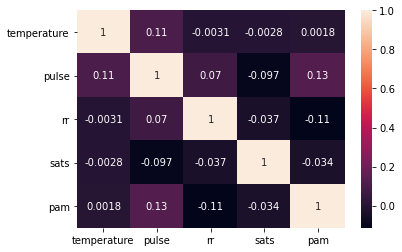

In [24]:
sns.heatmap(vitals.corr(), annot=True)

In [147]:
vital_models = {
    
    "Random Forest" : RandomForestClassifier(),
    "XGBClassifier" : XGBAdapter(),
    "Logistic Regression" : LogisticRegression(),
    "SVM" : SVC()

}

In [194]:
run_models_cross_val(vitals, y[vitals.index], vital_models, ratio_negatives_to_positives=-1)
run_models_cross_val(vitals, y[vitals.index], vital_models, ratio_negatives_to_positives=1)

Random Forest
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.998768,0.947479,0.997657,0.971917
Validation,0.976430,0.000893,0.016667,0.001695



XGBClassifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.978809,0.060676,1.000000,0.114338
Validation,0.977108,0.003452,0.192424,0.006759



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.977397,0.0,0.0,0.0
Validation,0.977354,0.0,0.0,0.0



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.977436,0.0,0.0,0.0
Validation,0.977436,0.0,0.0,0.0



Random Forest
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.999192,0.999292,0.999092,0.999192
Validation,0.554593,0.514120,0.561681,0.535560



XGBClassifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.940175,0.939745,0.940589,0.940118
Validation,0.548213,0.547740,0.550756,0.548640



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.591937,0.558792,0.598402,0.577869
Validation,0.580168,0.551426,0.584741,0.566302



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.572685,0.643814,0.563639,0.600806
Validation,0.582910,0.636105,0.575703,0.603125


In [198]:
vitals_ex = pd.merge(vitals, e_factors, left_index=True, right_index=True)
run_models_cross_val(vitals_ex, y[vitals_ex.index], vital_models, ratio_negatives_to_positives=1)

Random Forest
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.999949,0.999899,1.000000,0.999949
Validation,0.580194,0.536005,0.590223,0.560787



XGBClassifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.964680,0.961276,0.967820,0.964518
Validation,0.551376,0.535004,0.554121,0.543978



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.589258,0.565665,0.593509,0.579230
Validation,0.567377,0.554103,0.570883,0.559654



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.566217,0.577497,0.564802,0.570224
Validation,0.567865,0.575071,0.569652,0.570365


In [199]:
vitals_comorb = pd.merge(vitals, comorb, left_index=True, right_index=True)
run_models_cross_val(vitals_comorb, y[vitals_comorb.index], vital_models, ratio_negatives_to_positives=1)

Random Forest
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.999444,0.999393,0.999495,0.999444
Validation,0.571528,0.528707,0.579925,0.551753



XGBClassifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.940630,0.93671,0.944139,0.940385
Validation,0.564641,0.54231,0.567489,0.553492



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.589207,0.562531,0.594049,0.577823
Validation,0.581073,0.540459,0.587126,0.560716



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.567177,0.533823,0.572415,0.551883
Validation,0.558709,0.526847,0.562840,0.543448


In [188]:
vitals_comorb_ex = pd.merge(vitals_comorb, e_factors, left_index=True, right_index=True)
run_models_cross_val(vitals_comorb_ex, y[vitals_comorb_ex.index], vital_models, ratio_negatives_to_positives=1)

Random Forest
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,1.000000,1.000000,1.000000,1.000000
Validation,0.581551,0.537723,0.592185,0.561652



XGBClassifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.958012,0.953190,0.962471,0.957787
Validation,0.571945,0.549566,0.577513,0.562942



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.590117,0.571732,0.593337,0.582314
Validation,0.584284,0.556831,0.589482,0.570003



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.568896,0.529473,0.575023,0.550949
Validation,0.577915,0.533211,0.586465,0.556869


In [214]:
a_symptoms.dropna(how="all")

,ctab,labored_respiration,rhonchi,wheezes,days_since_symptom_onset
0,False,False,False,False,28.0
1,False,False,False,False,NaN
3,False,False,NaN,NaN,3.0
4,False,False,False,False,4.0
5,False,False,NaN,False,3.0
...,...,...,...,...,...
93989,NaN,False,NaN,NaN,NaN
93990,False,False,False,False,1.0
93991,NaN,False,NaN,NaN,NaN
93993,NaN,False,NaN,NaN,NaN
